In [1]:
%%HTML
# Basic styling for the notebook in vscode
<style>
    body {
        --vscode-font-family: "avenir";
        --vscode-font-weight: 500;
    }
</style>    

In [121]:
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from transformers import pipeline # pip install transformers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Attention, Input, Concatenate, Add, LayerNormalization
from tensorflow.keras.optimizers import Adam
from kerastuner import HyperModel
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from kerastuner.tuners import RandomSearch
import tensorflow as tf
import random
from sklearn.decomposition import PCA



module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from functions import add_growth_score_based_on_main_features, add_days_since_last_release_col, add_repo_age_days_col, convert_topics_to_embeddings, indexify_release_dates, add_lag_features_based_on_target

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
df = pd.read_csv('../data/github_data.csv')
df.head()

,org_name,repo_name,description,repo_url,topics,creation_date,update_date,release_tag,release_date,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers
0,aio-libs-abandoned,aioredis-py,asyncio (PEP 3156) Redis support,https://github.com/aio-libs-abandoned/aioredis-py,"python-3, asyncio, redis, redis-sentinel, pyth...",2014-05-25T19:29:57Z,2024-09-19T16:43:56Z,v0.1.1,2014-07-07 08:16:11+00:00,1,46,401,1851,244,1663
1,aio-libs-abandoned,aioredis-py,asyncio (PEP 3156) Redis support,https://github.com/aio-libs-abandoned/aioredis-py,"python-3, asyncio, redis, redis-sentinel, pyth...",2014-05-25T19:29:57Z,2024-09-19T16:43:56Z,v0.1.2,2014-07-31 07:52:08+00:00,2,72,661,2743,355,2665
2,aio-libs-abandoned,aioredis-py,asyncio (PEP 3156) Redis support,https://github.com/aio-libs-abandoned/aioredis-py,"python-3, asyncio, redis, redis-sentinel, pyth...",2014-05-25T19:29:57Z,2024-09-19T16:43:56Z,v0.1.3,2014-08-08 07:51:11+00:00,3,96,802,3631,489,3932
3,aio-libs-abandoned,aioredis-py,asyncio (PEP 3156) Redis support,https://github.com/aio-libs-abandoned/aioredis-py,"python-3, asyncio, redis, redis-sentinel, pyth...",2014-05-25T19:29:57Z,2024-09-19T16:43:56Z,v0.1.4,2014-09-22 19:50:09+00:00,4,99,1056,4013,620,4091
4,aio-libs,aiopg,aiopg is a library for accessing a PostgreSQL ...,https://github.com/aio-libs/aiopg,"asyncio, postgresql, sqlalchemy",2014-04-03T09:58:33Z,2024-09-17T10:57:37Z,v0.4.0,2014-10-02 09:33:16+00:00,1,95,922,3992,667,4414


In [4]:
# Functions Definitions
    
def provideMissingDesc(repo_name, description):
    df.loc[df['repo_name'] == repo_name, 'description'] = description

## Data Cleanup

In [5]:
print(df.shape)
print(df.describe())

(9087, 15)
       num_releases  num_open_issues  num_pull_requests      num_stars  \
count   9087.000000      9087.000000        9087.000000    9087.000000   
mean      14.161329       134.967536        1199.403544    5352.657423   
std        8.488365       325.736708        3354.410302    9214.548132   
min        1.000000         1.000000           1.000000       1.000000   
25%        7.000000         1.000000           1.000000       1.000000   
50%       13.000000        71.000000         499.000000    3316.000000   
75%       21.000000       141.000000        1069.000000    6336.500000   
max       30.000000      4879.000000       49697.000000  169998.000000   

          num_forks  num_watchers  
count   9087.000000    9087.00000  
mean     766.903048    5354.25498  
std     1801.675498    9213.98910  
min        1.000000       1.00000  
25%        1.000000       1.00000  
50%      421.000000    3325.00000  
75%      830.500000    6334.00000  
max    45377.000000  186449.00000 

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9087 entries, 0 to 9086
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   org_name           9087 non-null   object
 1   repo_name          9087 non-null   object
 2   description        9058 non-null   object
 3   repo_url           9087 non-null   object
 4   topics             8381 non-null   object
 5   creation_date      9087 non-null   object
 6   update_date        9087 non-null   object
 7   release_tag        9087 non-null   object
 8   release_date       9087 non-null   object
 9   num_releases       9087 non-null   int64 
 10  num_open_issues    9087 non-null   int64 
 11  num_pull_requests  9087 non-null   int64 
 12  num_stars          9087 non-null   int64 
 13  num_forks          9087 non-null   int64 
 14  num_watchers       9087 non-null   int64 
dtypes: int64(6), object(9)
memory usage: 1.0+ MB
None


There seem to be some missing values in the description and the release date / release tag columns. I visited the related repositories to extract some descriptions to fill up the gap.

In [7]:
df[df['description'].isna()].head(10)

,org_name,repo_name,description,repo_url,topics,creation_date,update_date,release_tag,release_date,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers
1297,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-15T14:52:59Z,11.0.0-SNAPSHOT.20220222040837,2022-02-22 04:17:49+00:00,1,1,1,1,1,1
1298,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-15T14:52:59Z,11.0.0-SNAPSHOT.20220222093559,2022-02-22 09:46:48+00:00,2,1,1,1,1,1
1302,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-15T14:52:59Z,11.0.0-SNAPSHOT.20220222230032,2022-02-22 23:07:52+00:00,3,1,1,1,1,1
1303,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-15T14:52:59Z,11.0.0-SNAPSHOT.20220223080646,2022-02-23 08:13:31+00:00,4,1,1,1,1,1
1304,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-15T14:52:59Z,11.0.0-SNAPSHOT.20220223141509,2022-02-23 14:24:39+00:00,5,1,1,1,1,1
1305,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-15T14:52:59Z,11.0.0-SNAPSHOT.20220223191115,2022-02-23 19:20:00+00:00,6,1,1,1,1,1
1306,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-15T14:52:59Z,11.0.0-SNAPSHOT.20220224141935,2022-02-24 14:26:48+00:00,7,1,1,1,1,1
1308,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-15T14:52:59Z,11.0.0-SNAPSHOT.20220227134704,2022-02-27 13:56:21+00:00,8,10,1,1,1,1
1310,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-15T14:52:59Z,11.0.0-SNAPSHOT.20220228005605,2022-02-28 01:03:48+00:00,9,62,1,1,1,1
1312,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-15T14:52:59Z,11.0.0-SNAPSHOT.20220228185039,2022-02-28 18:58:15+00:00,10,136,618,2490,338,2587


In [8]:
# Fix the missing description by manually copying description form the repo's README file

provideMissingDesc("ml-ferret", "An End-to-End MLLM that Accept Any-Form Referring and Ground Anything in Response.")
provideMissingDesc("ailab", "Real Cascade U-Nets for Anime Image Super Resolution")
provideMissingDesc("MTProxy", "Simple MT-Proto proxy")
provideMissingDesc("MLOps-Basics", "The goal of the series is to understand the basics of MLOps like model building, monitoring, configurations, testing, packaging, deployment, cicd, etc")
provideMissingDesc("gpt-llm-trainer", "The goal of this project is to explore an experimental new pipeline to train a high-performing task-specific model. We try to abstract away all the complexity, so it's as easy as possible to go from idea -> performant fully-trained model.")
provideMissingDesc("ml-mgie", "Guiding Instruction-based Image Editing via Multimodal Large Language Models")
provideMissingDesc("NLPIR", "NLPIR stores relevant files of the NLPIR big data semantic enhanced analysis platform")
provideMissingDesc("Roadmap-To-Learn-Generative-AI-In-2024", "Roadmap To Learn Generative AI In 2024")
provideMissingDesc("crewAI-examples", "crewAI is designed to facilitate the collaboration of role-playing AI agents. This is a collection of examples of different ways to use the crewAI framework to automate the processes")
provideMissingDesc("LLM-Agent-Survey", "A Survey on LLM-based Autonomous Agents")
provideMissingDesc("airsonic-advanced", "Airsonic-Advanced is a more modern implementation of the Airsonic fork with several key performance and feature enhancements. It adds and supersedes several features in Airsonic.")
provideMissingDesc("ai-component-generator", "This project generates almost any UI components with OpenAI's ChatGPT and allows you to copy the html code")

In [9]:
print(df['description'].isna().sum())

0


In [10]:
df[df['release_date'].isna()].head(10)

,org_name,repo_name,description,repo_url,topics,creation_date,update_date,release_tag,release_date,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers


Since the release_date feature is a very relevant feature for our model I'll drop rows that don't have a release_date.

In [11]:
df = df.dropna(subset=['release_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9087 entries, 0 to 9086
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   org_name           9087 non-null   object
 1   repo_name          9087 non-null   object
 2   description        9087 non-null   object
 3   repo_url           9087 non-null   object
 4   topics             8381 non-null   object
 5   creation_date      9087 non-null   object
 6   update_date        9087 non-null   object
 7   release_tag        9087 non-null   object
 8   release_date       9087 non-null   object
 9   num_releases       9087 non-null   int64 
 10  num_open_issues    9087 non-null   int64 
 11  num_pull_requests  9087 non-null   int64 
 12  num_stars          9087 non-null   int64 
 13  num_forks          9087 non-null   int64 
 14  num_watchers       9087 non-null   int64 
dtypes: int64(6), object(9)
memory usage: 1.0+ MB


In [12]:
num_na_values_per_repo = df.groupby('repo_name')['topics'].apply(lambda x: x.isna().sum())
num_na_values_per_repo = num_na_values_per_repo[num_na_values_per_repo > 0]
print(f"Number of NaN values in 'topics' column: {num_na_values_per_repo.head(50)}")

Number of NaN values in 'topics' column: repo_name
AI-on-the-edge-device          29
AI0x0.com                      29
AiNiee                         29
AirGuard                       17
Arcade-Learning-Environment    14
Auto-Synced-Translated-Dubs    23
FlagAI                         29
KMS_VL_ALL_AIO                 20
ParlAI                         22
PraisonAI                      29
RealChar                       29
VideoLingo                     18
Vitis-AI                       12
aicommits                      17
aiosql                         29
airsonic-advanced              29
airtable.js                    29
aitextgen                      12
chaiNNer                       29
gaianet-node                   15
gpt-ai-assistant               29
gptscript                      29
malmo                          20
mentat                         18
mesop                          25
mods                           13
new-api                        29
node-wit                       

In [13]:
# Save a backup copy of the topics with NaN value so that later I can verify the populated values
na_unique_indices = df[df['topics'].isna()].drop_duplicates(subset=['repo_name']).index
na_unique_indices

Index([  18,   29,   34,   81,  446,  515,  537,  566, 1028, 1049, 1182, 1297,
       1508, 2070, 2214, 2260, 2304, 2767, 3208, 3337, 4176, 4687, 4891, 5088,
       5442, 6091, 6416, 6996, 7206, 7340, 8377],
      dtype='int64')

In [14]:
len(df.topics.unique())

334

In [15]:
# Populate the missing topics with predefined values using the transformer library with facebook/bart-large-mnli model

# NLP - Natural Language Processing
# NLG - Natural Language Generation
# MT - Machine Translation
# ML - Machine Learning
# MML - Multi-Modal Learning
# RL - Reinforcement Learning
# ASR - Automatic Speech Recognition
# TTS - Text-to-Speech
# RPA - Robotic Process Automation
# IR - Information Retrieval
# DL - Deep Learning
# OCR - Optical Character Recognition


classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define candidate topics
candidate_topics = ["NLP", "NLG", "MT", "ML", "MML", "LLM", "RL", "ASR", "TTS", "RPA", "IR", "DL", "OCR", "python", "gpt"]

# Drop duplicates to get unique 'repo_name' and 'topics' combinations
unique_topics = df.drop_duplicates(subset=['repo_name', 'topics']).reset_index(drop=True)

# Apply classification only to rows where 'topics' is NaN
def classify_topic(row):
    if pd.isna(row['topics']):
        description = row['description'] if pd.notna(row['description']) else "No description available"
        candidate_topics_lower = [topic.lower() for topic in candidate_topics]
        return classifier(description, candidate_topics_lower)['labels'][0]
    else:
        return row['topics']

unique_topics['topics'] = unique_topics.apply(classify_topic, axis=1) # type: ignore

# Merge the updated topics back into the original DataFrame
df = pd.merge(df, unique_topics[['repo_name', 'topics']], 
            on=['repo_name'], how='left', suffixes=('', '_new'))

# Update the 'topics' column in the original DataFrame
df['topics'] = df['topics_new'].combine_first(df['topics'])

# Drop the helper column after merging
df.drop(columns=['topics_new'], inplace=True)

# Estimated 2m 11.4s

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [16]:
# Verify the populated NaN values
print("\nRows with NaN 'topics' before filling (unique per repo_name):")
print(df.loc[na_unique_indices[:-2]]['topics'].head(50))


Rows with NaN 'topics' before filling (unique per repo_name):
18         ocr
29         tts
34         mml
81          ir
446        asr
515        asr
537        asr
566     python
1028    python
1049       asr
1182       asr
1297       asr
1508       asr
2070       asr
2214       gpt
2260       nlg
2304       gpt
2767        ir
3208       llm
3337       llm
4176       asr
4687    python
4891       asr
5088       asr
5442       asr
6091       asr
6416       asr
6996       asr
7206       asr
Name: topics, dtype: object


In [17]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9087 entries, 0 to 9086
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   org_name           9087 non-null   object
 1   repo_name          9087 non-null   object
 2   description        9087 non-null   object
 3   repo_url           9087 non-null   object
 4   topics             9087 non-null   object
 5   creation_date      9087 non-null   object
 6   update_date        9087 non-null   object
 7   release_tag        9087 non-null   object
 8   release_date       9087 non-null   object
 9   num_releases       9087 non-null   int64 
 10  num_open_issues    9087 non-null   int64 
 11  num_pull_requests  9087 non-null   int64 
 12  num_stars          9087 non-null   int64 
 13  num_forks          9087 non-null   int64 
 14  num_watchers       9087 non-null   int64 
dtypes: int64(6), object(9)
memory usage: 1.0+ MB
None


In [18]:
df['creation_date'] = pd.to_datetime(df['creation_date'], utc=True)
df['update_date'] = pd.to_datetime(df['update_date'], utc=True)
df['release_date'] = pd.to_datetime(df['release_date'], utc=True)

In [19]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9087 entries, 0 to 9086
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   org_name           9087 non-null   object             
 1   repo_name          9087 non-null   object             
 2   description        9087 non-null   object             
 3   repo_url           9087 non-null   object             
 4   topics             9087 non-null   object             
 5   creation_date      9087 non-null   datetime64[ns, UTC]
 6   update_date        9087 non-null   datetime64[ns, UTC]
 7   release_tag        9087 non-null   object             
 8   release_date       9087 non-null   datetime64[ns, UTC]
 9   num_releases       9087 non-null   int64              
 10  num_open_issues    9087 non-null   int64              
 11  num_pull_requests  9087 non-null   int64              
 12  num_stars          9087 non-null   int64        

## EDA

In [20]:
# How many unique orgs are there?

print(f"{len(df.org_name.unique())} unique orgs")
print("-"*100)
print(df.org_name.unique()[:20],'...')

334 unique orgs
----------------------------------------------------------------------------------------------------
['aio-libs-abandoned' 'aio-libs' 'Farama-Foundation' 'wit-ai' 'microsoft'
 'puckel' 'snorkel-team' 'aisingapore' 'Tencent' 'Airtable' 'airsonic'
 'carla-simulator' 'airtap' 'BytomDAO' 'kubeflow' 'CIRCL'
 'facebookresearch' 'olivia-ai' 'byzer-org' 'sepandhaghighi'] ...


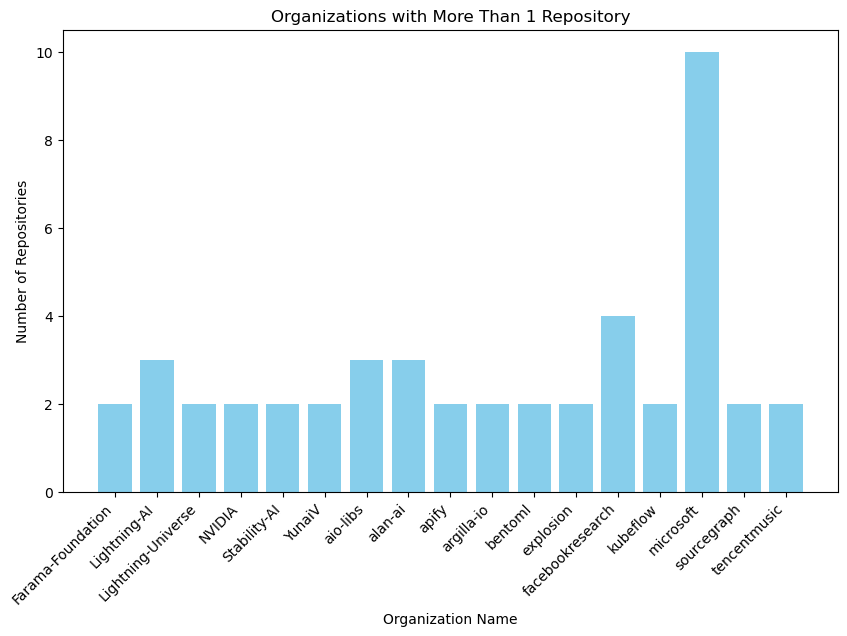

In [21]:
# Are there orgs that have multiple repos?

org_repo_count = df.groupby('org_name')['repo_name'].nunique().reset_index()
org_repo_count.columns = ['org_name', 'num_repos']
orgs_with_multiple_repos = org_repo_count[org_repo_count['num_repos'] > 1]

# Plot orgs that have more than one repos
plt.figure(figsize=(10, 6)) 
plt.bar(orgs_with_multiple_repos['org_name'], orgs_with_multiple_repos['num_repos'], color='skyblue')
plt.xlabel('Organization Name')
plt.ylabel('Number of Repositories')
plt.title('Organizations with More Than 1 Repository')
plt.xticks(rotation=45, ha='right')
plt.show()

In [22]:
# Which repos have the highest number of open issues?

open_pull_requests_per_repo = df.groupby(['creation_date', 'update_date', 'org_name', 'repo_name', 'num_pull_requests'])['num_open_issues'].sum().reset_index()
open_pull_requests_per_repo_sorted = open_pull_requests_per_repo.sort_values(by='num_open_issues', ascending=False)
open_pull_requests_per_repo_sorted = open_pull_requests_per_repo_sorted.reset_index(drop=True)

open_pull_requests_per_repo_sorted.head(20)

,creation_date,update_date,org_name,repo_name,num_pull_requests,num_open_issues
0,2015-08-24 07:27:28+00:00,2024-09-21 10:55:47+00:00,sourcegraph,sourcegraph-public-snapshot,40737,4879
1,2015-09-06 04:01:52+00:00,2024-09-21 21:31:23+00:00,pingcap,tidb,33772,4793
2,2015-08-24 07:27:28+00:00,2024-09-21 10:55:47+00:00,sourcegraph,sourcegraph-public-snapshot,36687,4620
3,2015-08-24 07:27:28+00:00,2024-09-21 10:55:47+00:00,sourcegraph,sourcegraph-public-snapshot,37032,4551
4,2015-09-06 04:01:52+00:00,2024-09-21 21:31:23+00:00,pingcap,tidb,36684,4516
5,2015-08-24 07:27:28+00:00,2024-09-21 10:55:47+00:00,sourcegraph,sourcegraph-public-snapshot,42198,4306
6,2015-08-24 07:27:28+00:00,2024-09-21 10:55:47+00:00,sourcegraph,sourcegraph-public-snapshot,37423,4157
7,2015-09-06 04:01:52+00:00,2024-09-21 21:31:23+00:00,pingcap,tidb,34116,4110
8,2016-06-02 08:28:18+00:00,2024-09-22 01:34:47+00:00,ClickHouse,ClickHouse,47185,4050
9,2015-09-06 04:01:52+00:00,2024-09-21 21:31:23+00:00,pingcap,tidb,38437,4030


In [23]:
# How many unique topics are there

print("Number of unique labels:", len(df.topics))
print("-"*100)
print("Unique topics:", list(df.topics)[:20])


Number of unique labels: 9087
----------------------------------------------------------------------------------------------------
Unique labels: ['python-3, asyncio, redis, redis-sentinel, python, redis-client, aioredis, python3, python36, python37, python38, python39, hacktoberfest, python310', 'python-3, asyncio, redis, redis-sentinel, python, redis-client, aioredis, python3, python36, python37, python38, python39, hacktoberfest, python310', 'python-3, asyncio, redis, redis-sentinel, python, redis-client, aioredis, python3, python36, python37, python38, python39, hacktoberfest, python310', 'python-3, asyncio, redis, redis-sentinel, python, redis-client, aioredis, python3, python36, python37, python38, python39, hacktoberfest, python310', 'asyncio, postgresql, sqlalchemy', 'asyncio, postgresql, sqlalchemy', 'asyncio, postgresql, sqlalchemy', 'asyncio, postgresql, sqlalchemy', 'asyncio, postgresql, sqlalchemy', 'asyncio, postgresql, sqlalchemy', 'asyncio, mysql, mariadb, sqlalchemy, p

Top Ten Recurrent Topics:
topics_split
ai                         4728
python                     2063
llm                        2051
machine-learning           1952
openai                     1697
chatgpt                    1588
deep-learning              1172
artificial-intelligence    1104
gpt                         970
gpt-4                       937
pytorch                     822
data-science                778
chatbot                     703
rag                         681
llmops                      607
hacktoberfest               600
generative-ai               563
ml                          562
mlops                       558
tensorflow                  552
Name: count, dtype: int64


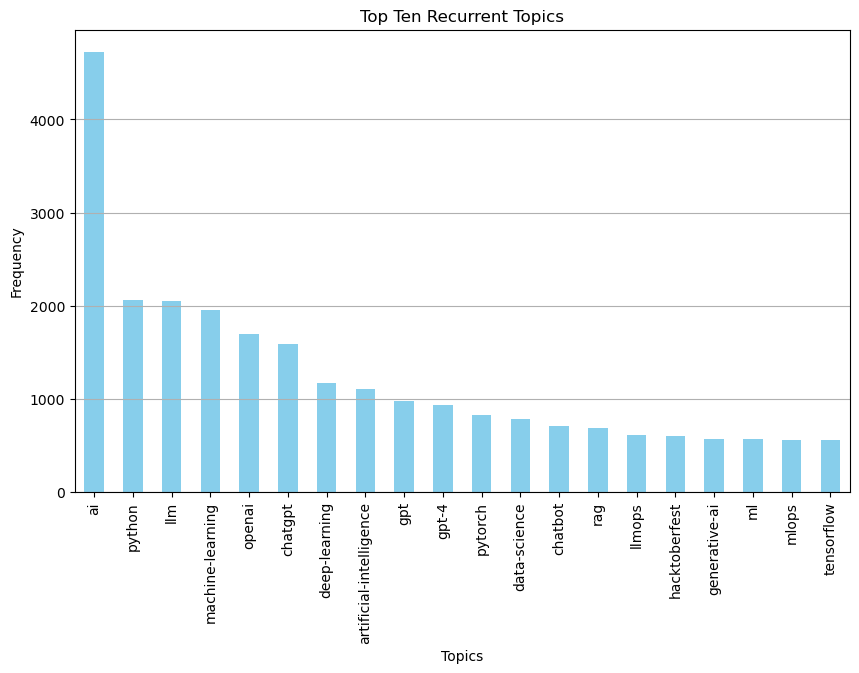

In [24]:
# What are the most recurrent topics 

topics_count_df = df.copy()

# Split the topics column by commas
topics_count_df['topics_split'] = topics_count_df['topics'].str.split(', ')

# Explode the list of topics into individual rows
df_exploded = topics_count_df.explode('topics_split')

# Count the frequency of each topic
topic_counts = df_exploded['topics_split'].value_counts()

# Get the top ten recurrent topics
top_topics = topic_counts.head(20)

# Display the top ten topics
print("Top Ten Recurrent Topics:")
print(top_topics)

# Visualize the top ten topics
plt.figure(figsize=(10, 6))
top_topics.plot(kind='bar', color='skyblue')
plt.title('Top Ten Recurrent Topics')
plt.xlabel('Topics')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

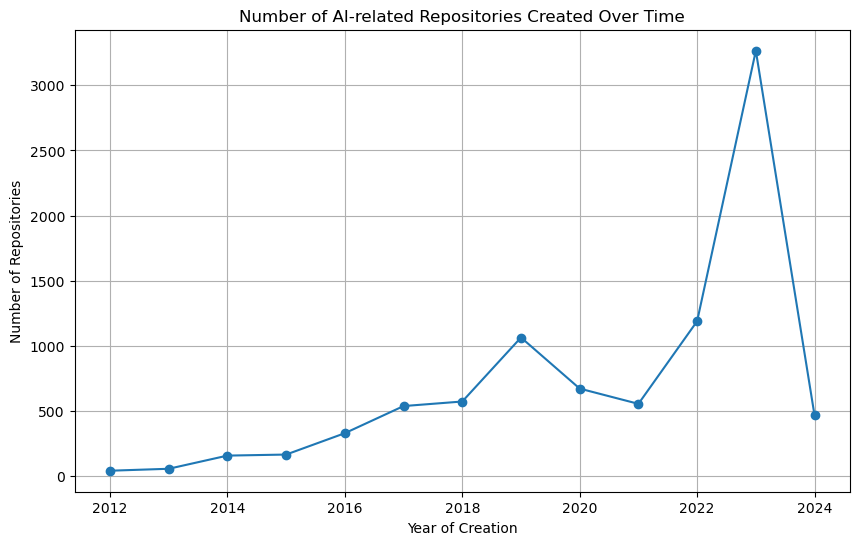

In [25]:
# Visualizing the progression of AI-related repos creation
df_creation = df.copy()
df_creation['creation_date'] = pd.to_datetime(df['creation_date'])

# Sort the DataFrame by 'creation_date' in ascending order
df_sorted = df_creation.sort_values(by='creation_date')

# Group by year see a trend over time
df_sorted['creation_year'] = df_sorted['creation_date'].dt.year
df_grouped = df_sorted.groupby('creation_year').size().reset_index(name='repo_count')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_grouped['creation_year'], df_grouped['repo_count'], marker='o')
plt.title('Number of AI-related Repositories Created Over Time')
plt.xlabel('Year of Creation')
plt.ylabel('Number of Repositories')
plt.grid(True)
plt.show()

       num_releases  num_open_issues  num_pull_requests      num_stars  \
count    364.000000       364.000000         364.000000     364.000000   
mean      25.964286       219.975275        1895.747253    9097.021978   
std        5.746369       493.743732        5121.256958   15215.524379   
min       13.000000         1.000000           1.000000       1.000000   
25%       22.000000        17.500000           1.000000    1015.000000   
50%       30.000000       124.000000         754.500000    5282.500000   
75%       30.000000       222.250000        1451.250000   10361.000000   
max       30.000000      4793.000000       47185.000000  169998.000000   

          num_forks   num_watchers  
count    364.000000     364.000000  
mean    1301.395604    9099.837912  
std     3159.630330   15694.401263  
min        1.000000       1.000000  
25%       97.250000    1074.750000  
50%      643.500000    5207.000000  
75%     1309.250000   10004.750000  
max    45377.000000  186449.000000  


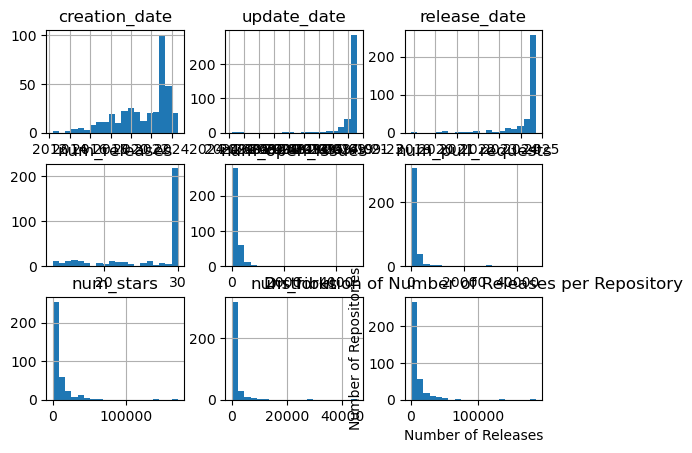

In [26]:
# How many releases are there per repo?

# Since the total number of release is at the last row of every repo we want to get that last row
df_sorted = df.sort_values(by=['repo_name', 'release_date'], ascending=[True, True])
last_rows_num_release = df_sorted.drop_duplicates(subset='repo_name', keep='last')

print(last_rows_num_release.describe())
last_rows_num_release.hist(bins=20)

plt.xlabel('Number of Releases')
plt.ylabel('Number of Repositories')
plt.title('Distribution of Number of Releases per Repository')
plt.show()

## Feature Engineering & Per-processing

In [27]:
df_main = df.copy()

In [28]:
columns_to_drop = ['description', 'release_tag', 'repo_url', 'update_date']
df_main.drop(columns=columns_to_drop, inplace=True)


df_main.head()

,org_name,repo_name,topics,creation_date,release_date,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers
0,aio-libs-abandoned,aioredis-py,"python-3, asyncio, redis, redis-sentinel, pyth...",2014-05-25 19:29:57+00:00,2014-07-07 08:16:11+00:00,1,46,401,1851,244,1663
1,aio-libs-abandoned,aioredis-py,"python-3, asyncio, redis, redis-sentinel, pyth...",2014-05-25 19:29:57+00:00,2014-07-31 07:52:08+00:00,2,72,661,2743,355,2665
2,aio-libs-abandoned,aioredis-py,"python-3, asyncio, redis, redis-sentinel, pyth...",2014-05-25 19:29:57+00:00,2014-08-08 07:51:11+00:00,3,96,802,3631,489,3932
3,aio-libs-abandoned,aioredis-py,"python-3, asyncio, redis, redis-sentinel, pyth...",2014-05-25 19:29:57+00:00,2014-09-22 19:50:09+00:00,4,99,1056,4013,620,4091
4,aio-libs,aiopg,"asyncio, postgresql, sqlalchemy",2014-04-03 09:58:33+00:00,2014-10-02 09:33:16+00:00,1,95,922,3992,667,4414


I want to create a new `growth_score` dependent variable which will be based on `num_stars` + `num_forks` + `num_pull_requests`
but first I need to scale those values because they are very different from each other.

In [29]:
df_main= add_growth_score_based_on_main_features(df_main)

df_main['growth_score'].tail()

9082    1.157314
9083    1.692062
9084    1.197326
9085    0.965517
9086    1.000000
Name: growth_score, dtype: float64

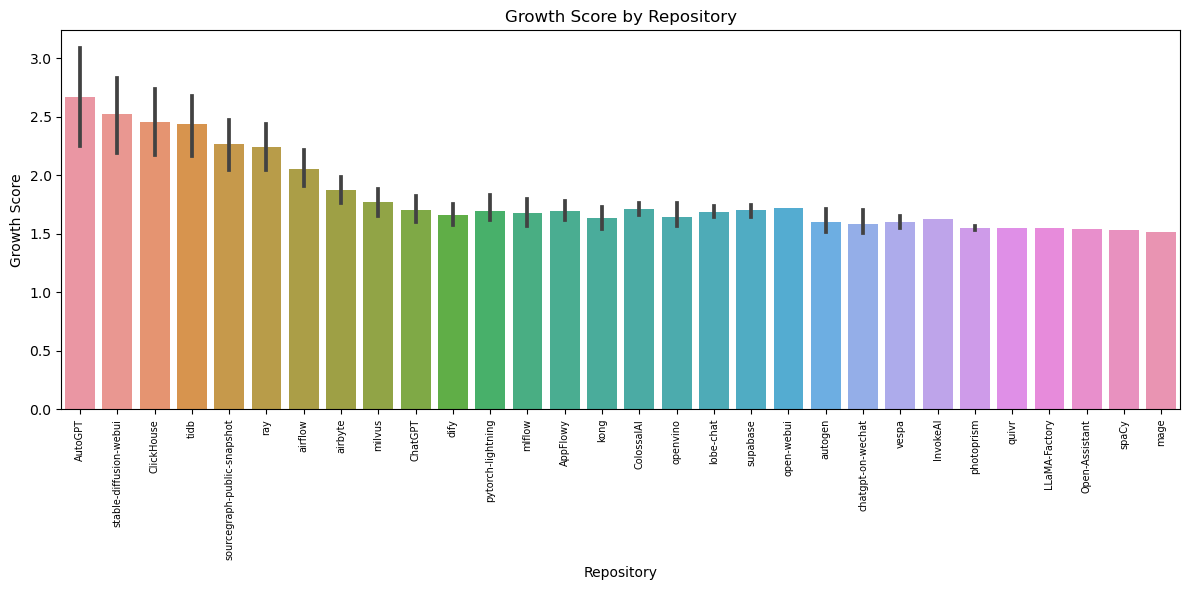

In [118]:
import seaborn as sns


df_filtered = df_main[df_main['growth_score'] > 1.5]

# Set the figure size
plt.figure(figsize=(12, 6))

# Bar plot showing growth_score for each repository
sns.barplot(x='repo_name', y='growth_score', data=df_filtered.sort_values(by='growth_score', ascending=False))

# Rotate x-axis labels for readability
plt.xticks(rotation=90, size=7)

# Add labels and title
plt.xlabel('Repository')
plt.ylabel('Growth Score')
plt.title('Growth Score by Repository')

# Show the plot
plt.tight_layout()
plt.show()

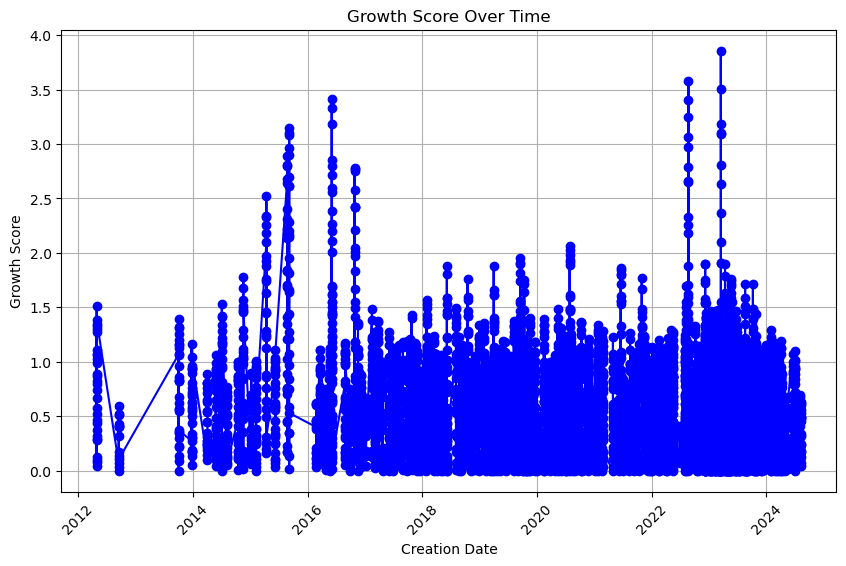

In [31]:
# Plot the growth score

# Sort the DataFrame by creation date to plot correctly
df_main = df_main.sort_values(by='creation_date')

# Plot growth_score over time
plt.figure(figsize=(10, 6))
plt.plot(df_main['creation_date'], df_main['growth_score'], marker='o', linestyle='-', color='b')
plt.xlabel('Creation Date')
plt.ylabel('Growth Score')
plt.title('Growth Score Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

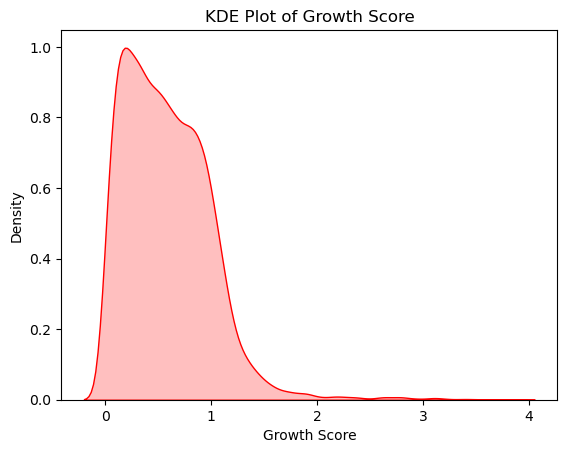

In [32]:
sns.kdeplot(df_main['growth_score'], shade=True, color="r")
plt.title('KDE Plot of Growth Score')
plt.xlabel('Growth Score')
plt.ylabel('Density')
plt.show()

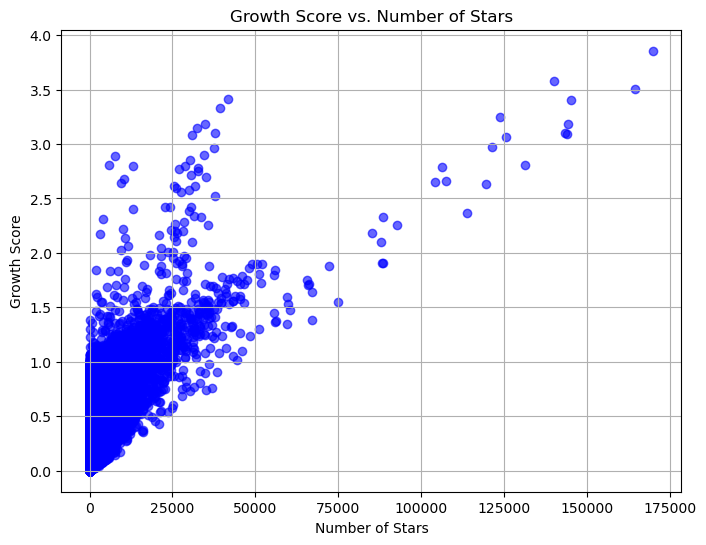

In [33]:
plt.figure(figsize=(8, 6))

# Scatter plot showing relationship between growth_score and num_stars
plt.scatter(df_main['num_stars'], df_main['growth_score'], alpha=0.6, color='b')

# Add labels and title
plt.xlabel('Number of Stars')
plt.ylabel('Growth Score')
plt.title('Growth Score vs. Number of Stars')

plt.grid(True)
plt.show()

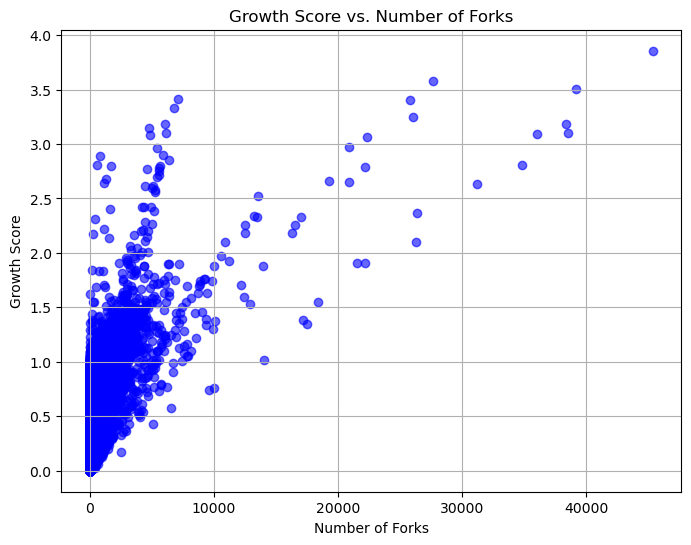

In [34]:
plt.figure(figsize=(8, 6))

# Scatter plot showing relationship between growth_score and num_stars
plt.scatter(df_main['num_forks'], df_main['growth_score'], alpha=0.6, color='b')

# Add labels and title
plt.xlabel('Number of Forks')
plt.ylabel('Growth Score')
plt.title('Growth Score vs. Number of Forks')

plt.grid(True)
plt.show()

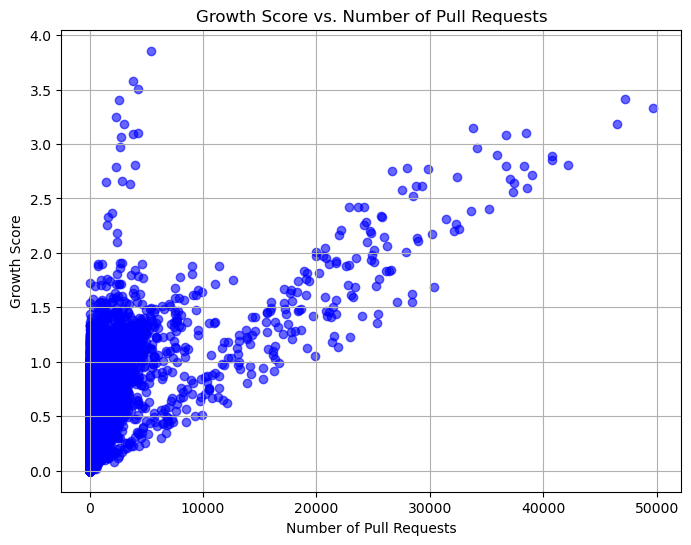

In [35]:
plt.figure(figsize=(8, 6))

# Scatter plot showing relationship between growth_score and num_stars
plt.scatter(df_main['num_pull_requests'], df_main['growth_score'], alpha=0.6, color='b')

# Add labels and title
plt.xlabel('Number of Pull Requests')
plt.ylabel('Growth Score')
plt.title('Growth Score vs. Number of Pull Requests')

plt.grid(True)
plt.show()

In [36]:
df_main = convert_topics_to_embeddings(df_main)
df_main.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/charles.hanna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,org_name,repo_name,creation_date,release_date,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers,...,374,375,376,377,378,379,380,381,382,383
430,magefree,mage,2012-04-27 13:18:34+00:00,2019-12-07 17:15:31+00:00,1,137,985,3674,527,4053,...,0.117142,0.070474,0.056391,-0.066624,0.037222,-0.044244,0.05621,0.0316,-0.004359,0.056011
538,magefree,mage,2012-04-27 13:18:34+00:00,2020-04-18 22:13:47+00:00,11,487,1279,1,1,1,...,0.117142,0.070474,0.056391,-0.066624,0.037222,-0.044244,0.05621,0.0316,-0.004359,0.056011
594,magefree,mage,2012-04-27 13:18:34+00:00,2020-06-20 07:43:29+00:00,12,553,1232,1,1,1,...,0.117142,0.070474,0.056391,-0.066624,0.037222,-0.044244,0.05621,0.0316,-0.004359,0.056011
611,magefree,mage,2012-04-27 13:18:34+00:00,2020-07-10 15:58:43+00:00,13,723,2806,2852,632,2850,...,0.117142,0.070474,0.056391,-0.066624,0.037222,-0.044244,0.05621,0.0316,-0.004359,0.056011
1089,magefree,mage,2012-04-27 13:18:34+00:00,2021-09-05 19:04:06+00:00,27,1305,4375,934,540,992,...,0.117142,0.070474,0.056391,-0.066624,0.037222,-0.044244,0.05621,0.0316,-0.004359,0.056011


I want also to introduce 2 new features `repo_age_days` and `days_since_last_release` in order to better help the model recognize temporal data

In [37]:
df_main = add_repo_age_days_col(df_main)
df_main = add_days_since_last_release_col(df_main)

df_main.head()

,org_name,repo_name,release_date,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers,growth_score,...,376,377,378,379,380,381,382,383,repo_age_days,days_since_last_release
430,magefree,mage,2019-12-07 17:15:31+00:00,1,137,985,3674,527,4053,0.102612,...,0.056391,-0.066624,0.037222,-0.044244,0.05621,0.0316,-0.004359,0.056011,4535,1755
538,magefree,mage,2020-04-18 22:13:47+00:00,11,487,1279,1,1,1,0.470175,...,0.056391,-0.066624,0.037222,-0.044244,0.05621,0.0316,-0.004359,0.056011,4535,1622
594,magefree,mage,2020-06-20 07:43:29+00:00,12,553,1232,1,1,1,0.517242,...,0.056391,-0.066624,0.037222,-0.044244,0.05621,0.0316,-0.004359,0.056011,4535,1559
611,magefree,mage,2020-07-10 15:58:43+00:00,13,723,2806,2852,632,2850,0.664205,...,0.056391,-0.066624,0.037222,-0.044244,0.05621,0.0316,-0.004359,0.056011,4535,1539
1089,magefree,mage,2021-09-05 19:04:06+00:00,27,1305,4375,934,540,992,1.274572,...,0.056391,-0.066624,0.037222,-0.044244,0.05621,0.0316,-0.004359,0.056011,4535,1117


After training the model, I noticed that there are lots of spikes related to the target variable, reducing those outliers should help the model fit better.

<Axes: xlabel='growth_score'>

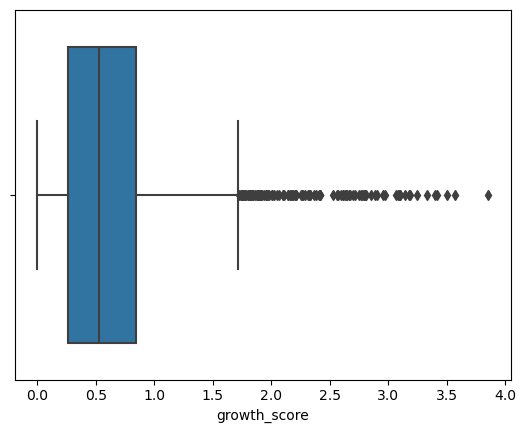

In [38]:
# Checking for outliers
sns.boxplot(x=df_main['growth_score'])

In [39]:
def detect_outliers_z_score(df, column):
    # the threshold determines the removal of the outliers that are over the specified threshold value
    threshold = 3
    mean = np.mean(df[column])
    std = np.std(df[column])
    z_scores = (df[column] - mean) / std
    return df[np.abs(z_scores) > threshold]

# Detect outliers in the 'growth_score' column
outliers = detect_outliers_z_score(df_main, 'growth_score')
print(len(outliers))
print(outliers)

99
                  org_name repo_name              release_date  num_releases  \
6711                apache   airflow 2024-06-10 10:58:26+00:00            24   
6072                apache   airflow 2024-05-06 10:30:55+00:00            23   
6882                apache   airflow 2024-06-19 00:26:03+00:00            25   
8049                apache   airflow 2024-08-16 01:53:36+00:00            28   
7558                apache   airflow 2024-07-24 12:45:34+00:00            27   
...                    ...       ...                       ...           ...   
3309  Significant-Gravitas   AutoGPT 2023-07-28 12:42:29+00:00            17   
3710  Significant-Gravitas   AutoGPT 2023-09-17 00:02:08+00:00            19   
5944  Significant-Gravitas   AutoGPT 2024-04-26 20:15:57+00:00            21   
4448  Significant-Gravitas   AutoGPT 2023-12-14 15:17:16+00:00            20   
9034            langgenius      dify 2024-09-20 10:25:46+00:00            30   

      num_open_issues  num_pull_requ

In [40]:
# Remove outliers detected by the previous step
df_cleaned = df_main[~df_main.index.isin(outliers.index)]

<Axes: xlabel='growth_score'>

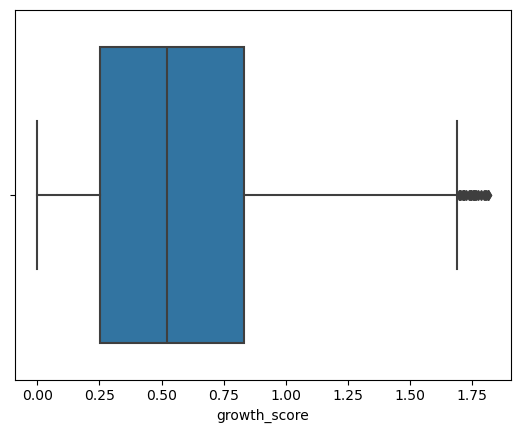

In [41]:
sns.boxplot(x=df_cleaned['growth_score'])

In [42]:
df_cleaned = indexify_release_dates(df_cleaned)
df_cleaned.head()

,org_name,repo_name,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers,growth_score,0,...,376,377,378,379,380,381,382,383,repo_age_days,days_since_last_release
release_date,,,,,,,,,,,,,,,,,,,,,
2014-07-07 08:16:11+00:00,aio-libs-abandoned,aioredis-py,1,46,401,1851,244,1663,0.042426,-0.051876,...,-0.017381,-0.052809,0.060830,0.022419,0.009335,0.051719,0.054389,0.041278,3777,3734
2014-07-31 07:52:08+00:00,aio-libs-abandoned,aioredis-py,2,72,661,2743,355,2665,0.100538,-0.051876,...,-0.017381,-0.052809,0.060830,0.022419,0.009335,0.051719,0.054389,0.041278,3777,3710
2014-08-08 07:51:11+00:00,aio-libs-abandoned,aioredis-py,3,96,802,3631,489,3932,0.157750,-0.051876,...,-0.017381,-0.052809,0.060830,0.022419,0.009335,0.051719,0.054389,0.041278,3777,3702
2014-09-22 19:50:09+00:00,aio-libs-abandoned,aioredis-py,4,99,1056,4013,620,4091,0.203946,-0.051876,...,-0.017381,-0.052809,0.060830,0.022419,0.009335,0.051719,0.054389,0.041278,3777,3657
2014-10-02 09:33:16+00:00,aio-libs,aiopg,1,95,922,3992,667,4414,0.099626,-0.040947,...,-0.040227,0.045241,0.011745,-0.014607,0.043373,-0.011810,0.087497,-0.039265,3829,3647


## Timeseries Analysis

<Axes: >

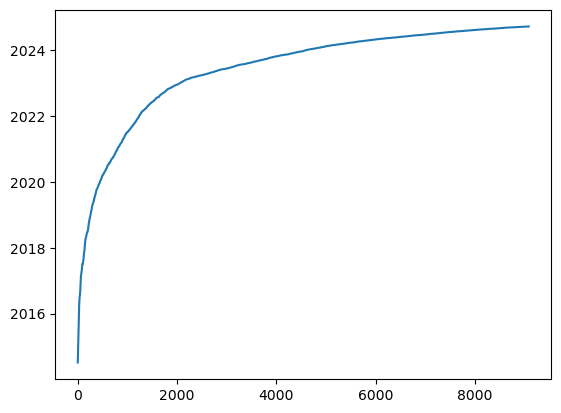

In [43]:
df['release_date'].plot()
# @TODO LABELS

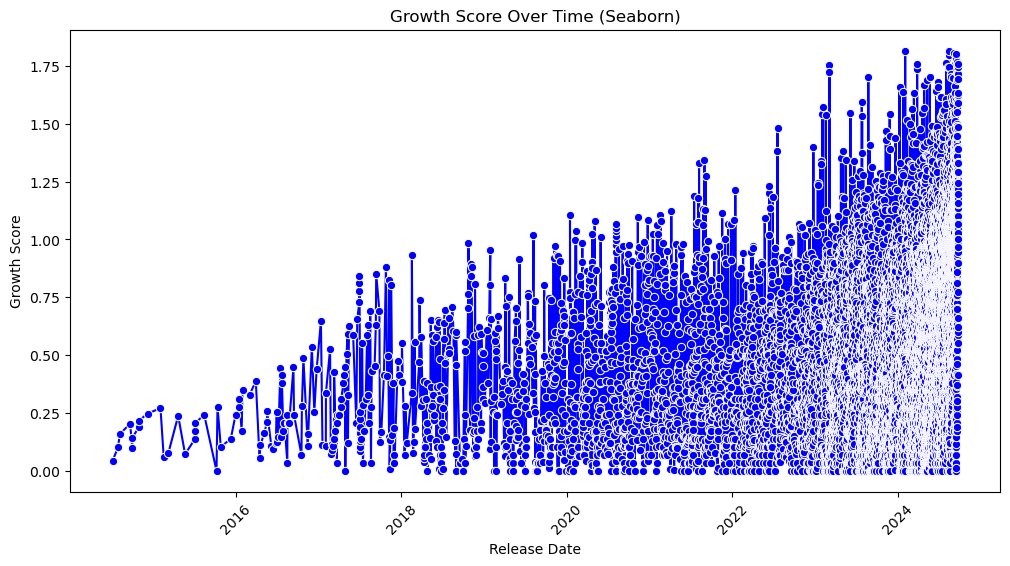

In [44]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(x=df_cleaned.index, y=df_cleaned['growth_score'], marker='o', color='b')
plt.title('Growth Score Over Time (Seaborn)')
plt.xlabel('Release Date')
plt.ylabel('Growth Score')
plt.xticks(rotation=45)
plt.show()

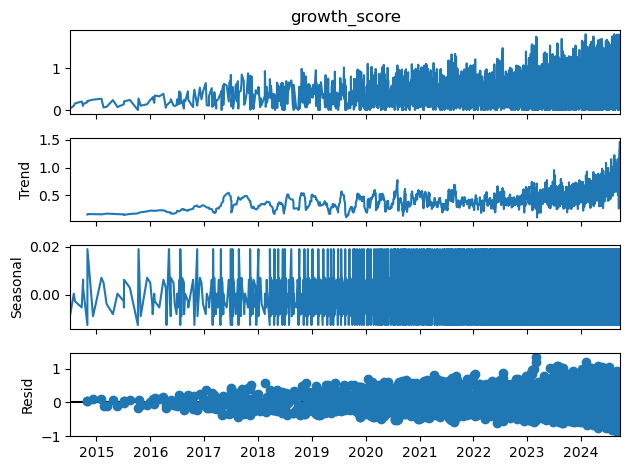

In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(df_cleaned['growth_score'], model='additive', period=12)

# Plot the decomposed components
decomposition.plot()
plt.show()

In [47]:
print(last_rows_num_release.describe()) 

       num_releases  num_open_issues  num_pull_requests      num_stars  \
count    364.000000       364.000000         364.000000     364.000000   
mean      25.964286       219.975275        1895.747253    9097.021978   
std        5.746369       493.743732        5121.256958   15215.524379   
min       13.000000         1.000000           1.000000       1.000000   
25%       22.000000        17.500000           1.000000    1015.000000   
50%       30.000000       124.000000         754.500000    5282.500000   
75%       30.000000       222.250000        1451.250000   10361.000000   
max       30.000000      4793.000000       47185.000000  169998.000000   

          num_forks   num_watchers  
count    364.000000     364.000000  
mean    1301.395604    9099.837912  
std     3159.630330   15694.401263  
min        1.000000       1.000000  
25%       97.250000    1074.750000  
50%      643.500000    5207.000000  
75%     1309.250000   10004.750000  
max    45377.000000  186449.000000  


In [48]:
# Since the min num_release is 6 of I'll create 5 lag features. Otherwise a higher number will lead to lots of NaN values.
df_cleaned_with_lag = add_lag_features_based_on_target(df_cleaned, num=5)
df_cleaned_with_lag.head()

,org_name,repo_name,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers,growth_score,0,...,381,382,383,repo_age_days,days_since_last_release,growth_score_lag_1,growth_score_lag_2,growth_score_lag_3,growth_score_lag_4,growth_score_lag_5
release_date,,,,,,,,,,,,,,,,,,,,,
2014-10-02 11:37:30+00:00,aio-libs,aiopg,2,113,1018,4813,617,4263,0.142648,-0.040947,...,-0.01181,0.087497,-0.039265,3829,3647,0.099626,0.203946,0.157750,0.100538,0.042426
2014-10-31 13:12:25+00:00,aio-libs,aiopg,3,130,1078,5097,692,4864,0.188370,-0.040947,...,-0.01181,0.087497,-0.039265,3829,3618,0.142648,0.099626,0.203946,0.157750,0.100538
2014-10-31 18:56:26+00:00,aio-libs,aiopg,4,128,1142,4665,615,4309,0.216516,-0.040947,...,-0.01181,0.087497,-0.039265,3829,3618,0.188370,0.142648,0.099626,0.203946,0.157750
2014-12-08 17:33:24+00:00,aio-libs,aiopg,5,119,1009,4513,614,4572,0.246972,-0.040947,...,-0.01181,0.087497,-0.039265,3829,3580,0.216516,0.188370,0.142648,0.099626,0.203946
2015-02-03 20:00:25+00:00,aio-libs,aiopg,6,113,917,3882,585,3921,0.270531,-0.040947,...,-0.01181,0.087497,-0.039265,3829,3523,0.246972,0.216516,0.188370,0.142648,0.099626


In [115]:
# Perform the ADF test
result = adfuller(df_cleaned_with_lag['growth_score'].dropna())

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -4.810579688652279
p-value: 5.1907372242163535e-05


The data is stationary:
-  the ADF statistic of -4.81 is quite negative, which strongly suggests that your time series data is stationary.
- Since the p-value is much lower than the usual significance level of 0.05, we can reject the null hypothesis that the data is non-stationary. This confirms that your data is stationary.

In [49]:
# Remove no-longer needed features
df_cleaned_with_lag = df_cleaned_with_lag.drop(columns=['org_name', 'repo_name'])
df_cleaned_with_lag.head()

,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers,growth_score,0,1,2,...,381,382,383,repo_age_days,days_since_last_release,growth_score_lag_1,growth_score_lag_2,growth_score_lag_3,growth_score_lag_4,growth_score_lag_5
release_date,,,,,,,,,,,,,,,,,,,,,
2014-10-02 11:37:30+00:00,2,113,1018,4813,617,4263,0.142648,-0.040947,-0.042826,-0.129569,...,-0.01181,0.087497,-0.039265,3829,3647,0.099626,0.203946,0.157750,0.100538,0.042426
2014-10-31 13:12:25+00:00,3,130,1078,5097,692,4864,0.188370,-0.040947,-0.042826,-0.129569,...,-0.01181,0.087497,-0.039265,3829,3618,0.142648,0.099626,0.203946,0.157750,0.100538
2014-10-31 18:56:26+00:00,4,128,1142,4665,615,4309,0.216516,-0.040947,-0.042826,-0.129569,...,-0.01181,0.087497,-0.039265,3829,3618,0.188370,0.142648,0.099626,0.203946,0.157750
2014-12-08 17:33:24+00:00,5,119,1009,4513,614,4572,0.246972,-0.040947,-0.042826,-0.129569,...,-0.01181,0.087497,-0.039265,3829,3580,0.216516,0.188370,0.142648,0.099626,0.203946
2015-02-03 20:00:25+00:00,6,113,917,3882,585,3921,0.270531,-0.040947,-0.042826,-0.129569,...,-0.01181,0.087497,-0.039265,3829,3523,0.246972,0.216516,0.188370,0.142648,0.099626


In [50]:
df_cleaned_with_lag['growth_score'].describe()

count    8983.000000
mean        0.562362
std         0.362887
min         0.000000
25%         0.254725
50%         0.522606
75%         0.831310
max         1.816198
Name: growth_score, dtype: float64

In [51]:
df_cleaned_with_lag['growth_score'] = np.log1p(df_cleaned_with_lag['growth_score'])

In [52]:
df_cleaned_with_lag['growth_score'].describe()

count    8983.000000
mean        0.419591
std         0.230581
min         0.000000
25%         0.226917
50%         0.420423
75%         0.605032
max         1.035388
Name: growth_score, dtype: float64

In [53]:
df_cleaned_with_lag['growth_score']

release_date
2014-10-02 11:37:30+00:00    0.133349
2014-10-31 13:12:25+00:00    0.172583
2014-10-31 18:56:26+00:00    0.195991
2014-12-08 17:33:24+00:00    0.220718
2015-02-03 20:00:25+00:00    0.239435
                               ...   
2024-09-21 15:00:46+00:00    0.768864
2024-09-21 17:08:51+00:00    0.990308
2024-09-21 20:35:49+00:00    0.787241
2024-09-21 21:24:37+00:00    0.675755
2024-09-22 02:34:13+00:00    0.693147
Name: growth_score, Length: 8983, dtype: float64

## Model Development

In [54]:
# Define the input and target variables
X = df_cleaned_with_lag.drop(columns=['growth_score']).values
y = df_cleaned_with_lag['growth_score'].values

X.shape

(8983, 397)

In [55]:
# Split the data into testing and training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
# Scale the input variables
scaler_X = MinMaxScaler()
# Fit the scaler only on the training data
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
joblib.dump(scaler_X, '../models/final_input_scaler.pkl')


# Scale the target variable as well
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))
joblib.dump(scaler_y, '../models/final_target_scaler.pkl')

print(X_train_scaled.shape)
print(y_train_scaled.shape)
print(X_test_scaled.shape)
print(y_test_scaled.shape)

(7186, 397)
(7186, 1)
(1797, 397)
(1797, 1)


Explained variance ratio by PCA: 0.98


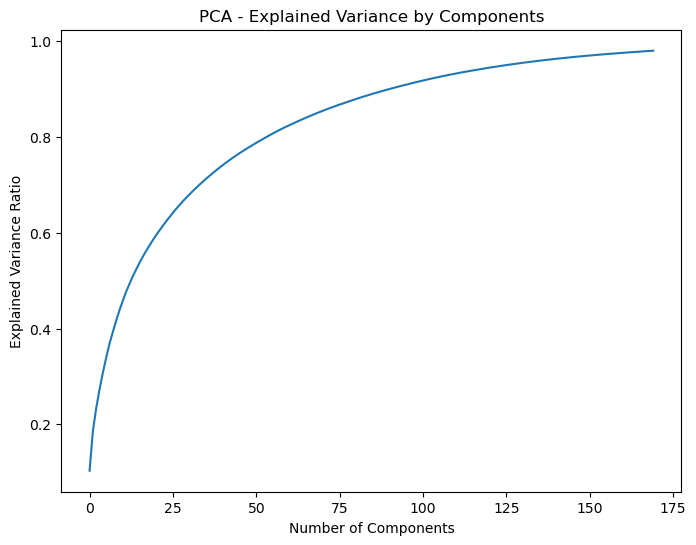

(7186, 170)


In [57]:
# Set the number of components to retain - 98% of features
pca = PCA(n_components=0.98)

# Fit PCA on training data and transform both train and test sets
X_train_scaled_pca = pca.fit_transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)
joblib.dump(pca, '../models/pca_model.pkl')

print(f'Explained variance ratio by PCA: {np.sum(pca.explained_variance_ratio_):.2f}')

plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA - Explained Variance by Components')
plt.show()

print(X_train_scaled_pca.shape)

After PCA the features were reduced from 397 to 170 features while still explaining 98% of the variance in the original data.

In [127]:
# Defining the timesteps and n_features

n_timesteps = 6
n_features_pca = X_train_scaled_pca.shape[1]
n_features = X_train_scaled.shape[1]


In [129]:
# Define the hypermodel for GRU model - this is a Gridsearch functionality to find the best values for the hyper parameters
class GRUHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        # Input layer
        input_layer = Input(shape=self.input_shape)
        
        # GRU layer with return_sequences=True for the Attention mechanism
        gru_out = GRU(units=hp.Int('units', min_value=16, max_value=256, step=16),
                      return_sequences=True)(input_layer)
        
        # Attention layer
        attention_out = Attention()([gru_out, gru_out])  # Self-attention

        # Optionally, concatenate the attention output with GRU output
        combined_out = Concatenate()([gru_out, attention_out])

        # Flatten the combined output for feeding into Dense layers
        combined_out = Dense(units=hp.Int('dense_units', min_value=16, max_value=128, step=16), 
                             activation='relu')(combined_out)

        # Dropout layer for regularization
        x = Dropout(hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1))(combined_out)
        
        # Output layer for regression
        output = Dense(1)(x)
        
        # Define the model with the input and output layers
        model = Model(inputs=input_layer, outputs=output)

        # Compile the model with the optimizer and loss function
        model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate',
                                                            min_value=1e-5,
                                                            max_value=1e-2,
                                                            sampling='LOG')),
                      loss='mean_squared_error')
        return model


In [131]:
class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(
            LSTM(
                units=hp.Int("units", min_value=16, max_value=256, step=16),
                return_sequences=False,
                input_shape=self.input_shape,
                activation='relu'
            )
        )
        model.add(
            Dropout(
                rate=hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1)
            )
        )
        model.add(Dense(10, activation='relu'))
        model.add(
            Dense(
                1,
                activation='exponential'  # For regression tasks, linear activation is used
            )
        )

        model.compile(
            optimizer=Adam(
                learning_rate=hp.Float("learning_rate", min_value=1e-7, max_value=0.001, sampling="LOG")
            ),
            loss="mean_squared_error"
        )
        return model

In [63]:
def create_lstm_model(input_shape, learning_rate=1e-6, lstm_units=256, dropout_rate=0.5):
    # Input layer
    input_layer = Input(shape=input_shape)
    # LSTM layer with return_sequences=True to output the full sequence
    lstm_out = LSTM(units=lstm_units, return_sequences=True)(input_layer)
    attention_out = Attention()([lstm_out, lstm_out])
    # Flatten the attention output and concatenate with LSTM output
    combined_out = Concatenate()([lstm_out, attention_out]) 
    x = Dense(10, activation='relu')(combined_out)
    x = Dropout(dropout_rate)(x)
    output = Dense(1, activation='exponential')(x)  # Output layer for regression
    model = Model(inputs=input_layer, outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

    # model = Sequential()
    
    # # First LSTM layer
    # model.add(LSTM(units=lstm_units, return_sequences=False, input_shape=input_shape))
    # model.add(Dropout(dropout_rate))
    # model.add(Dense(10, activation='relu'))
    # # Output layer (Dense layer with 1 unit because it's regression)
    # model.add(Dense(1, activation='exponential'))

    # # Compile the model with Adam optimizer and a custom learning rate
    # optimizer = Adam(learning_rate=learning_rate)
    # model.compile(optimizer=optimizer, loss='mean_squared_error')

    # return model

In [64]:
def create_gru_attention_model(input_shape, learning_rate=1e-4, gru_units=128, dropout_rate=0.5):

    input_layer = Input(shape=input_shape)
    gru_output = GRU(units=gru_units, return_sequences=True)(input_layer)
    gru_output = Dropout(dropout_rate)(gru_output)
    attention_output = Attention()([gru_output, gru_output])
    context_vector = Add()([gru_output, attention_output])
    context_vector = LayerNormalization()(context_vector)
    context_vector = context_vector[:, -1, :] 
    dense_output = Dense(64, activation='relu')(context_vector)
    dense_output = Dropout(dropout_rate)(dense_output)
    output = Dense(1, activation='exponential')(dense_output)  # Use 'linear' for regression tasks
    
    # Create model
    model = Model(inputs=input_layer, outputs=output)
    
    # Compile the model with Adam optimizer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

In [ ]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Hyperparameters
batch_size = 64
units = 64
learning_rate= 1e-5
dropout_rate = 0.05
patience = 25
epochs = 900

train_generator = TimeseriesGenerator(X_train_scaled_pca, y_train_scaled, length=n_timesteps, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test_scaled_pca, y_test_scaled, length=n_timesteps, batch_size=batch_size)

input_shape = (n_timesteps, n_features_pca)

#### Grid Search

In [133]:
# Commenting this out so that it doesn't run when "Run All" is pressed because it takes a very long time

# hypermodel = GRUHyperModel(input_shape=(n_timesteps, n_features))

# # Set up the tuner
# tuner = RandomSearch(
#     hypermodel,
#     objective='val_loss',
#     max_trials=2,  # Number of trials to run
#     executions_per_trial=10,  # Number of models to average for each trial
#     directory='../models/grid_search_results/gru_tuning',  # Directory to save logs and models
#     project_name='gru_tune')

# # Run the search
# tuner.search(train_generator, validation_data=test_generator, epochs=100)

# # Print the best hyperparameters
# best_hps = tuner.get_best_hyperparameters()[0]
# print(f"Best units: {best_hps.get('units')}")
# print(f"Best dropout_rate: {best_hps.get('dropout_rate')}")
# print(f"Best learning_rate: {best_hps.get('learning_rate')}")

In [137]:
# Commenting this out so that it doesn't run when "Run All" is pressed because it takes a very long time

# Set up the tuner
# tuner = RandomSearch(
#     LSTMHyperModel(input_shape),
#     objective="val_loss",
#     max_trials=10,  # Number of different hyperparameter combinations to try
#     executions_per_trial=1,  # Number of times to train the model with each hyperparameter set
#     directory="../models/grid_search_results/lstm_tuning",
#     project_name="lstm_hyperparameter_search"
# )

# tuner.search_space_summary()

# # Assuming you have your training and validation data prepared as train_generator and val_generator
# tuner.search(train_generator, validation_data=test_generator, epochs=100)

# # Get the best model and parameters
# best_model = tuner.get_best_models(num_models=1)[0]
# best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"Best Hyperparameters: {best_hyperparameters.values}")

#### Model Training

In [95]:
# LSTM Model
# Best Hyperparameters: {'units': 192, 'dropout_rate': 0.2, 'learning_rate': 7.727252029218442e-05}
# model = create_lstm_model(input_shape=input_shape, learning_rate=learning_rate, lstm_units=units, dropout_rate=dropout_rate)

# GRU Model
# Best Hyperparameters: {'units': 64, 'dropout_rate': 0.05, 'learning_rate': 1e-5}
model = create_gru_attention_model(input_shape=input_shape, learning_rate=learning_rate, gru_units=units, dropout_rate=dropout_rate)

# Early stopping so it stops when the learning stops learning & saves the model with the best result
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('../models/best_rnn_model.keras', save_best_only=True, monitor='val_loss')

history = model.fit(train_generator, epochs=epochs, batch_size=batch_size, validation_data=test_generator, callbacks=[early_stopping, model_checkpoint])

input_shape


Epoch 1/900
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 50.9701 - val_loss: 38.1385
Epoch 2/900
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 39.1943 - val_loss: 29.1296
Epoch 3/900
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 28.8406 - val_loss: 23.3153
Epoch 4/900
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 25.1952 - val_loss: 19.1387
Epoch 5/900
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.1585 - val_loss: 16.0410
Epoch 6/900
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 15.5323 - val_loss: 13.6331
Epoch 7/900
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 13.8207 - val_loss: 11.7284
Epoch 8/900
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.0218 - val_loss: 10.1893
Epoch 9/900
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.8445 - val_loss: 8.9279
Epoch 10/900
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.5205 - val_loss: 7.8491
Epoch 11/900
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.1232 - val_loss: 6.9691
Epoch 12/900
113/113 ━━━

(6, 170)

In [96]:
# Load the saved model
model = load_model('../models/best_rnn_model.keras')

In [97]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 6, 170)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 6, 64)     │     45,312 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 6, 64)     │          0 │ gru_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ (None, 6, 64)     │          0 │ dropout_4[0][0],  │
│ (Attention)         │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 6, 64)     │          0 │ dropout_4[0][0],  │
│                     │                   │            │ attention_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 6, 64)     │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 64)        │          0 │ layer_normalizat… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      4,160 │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 148,997 (582.02 KB)

 Trainable params: 49,665 (194.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 99,332 (388.02 KB)

#### Model Evaluation

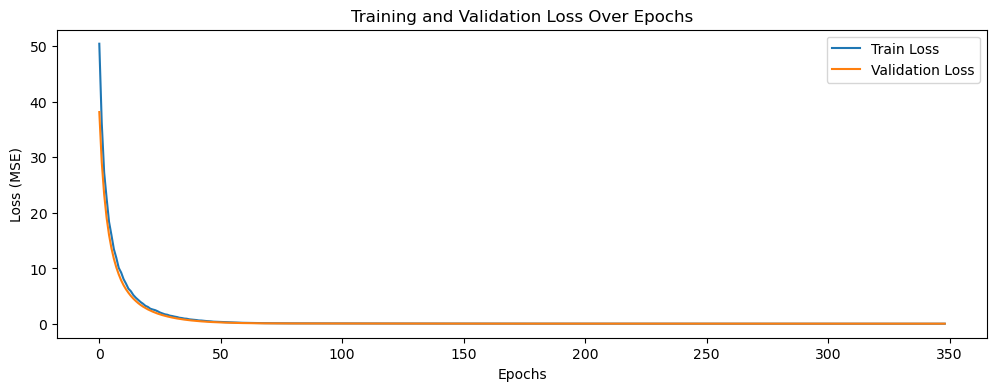

In [98]:
plt.figure(figsize=(12,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [99]:
test_loss = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0535  
Test Loss: 0.05461142584681511


In [135]:
scaler_y = joblib.load('../models/final_target_scaler.pkl')

y_pred_scaled = model.predict(test_generator)

# for GRU model and LSTM with return_sequences=False
y_pred = scaler_y.inverse_transform(y_pred_scaled).reshape(-1)

print(y_pred.shape)

# Initialize a list for the actual values
y_actual_scaled = []

# Extract actual values from test_generator
for i in range(len(test_generator)):
    _, target = test_generator[i]  # target is the true y values for the batch
    y_actual_scaled.append(target)

# # Flatten the array to match y_pred
y_actual_scaled = np.concatenate(y_actual_scaled).reshape(-1)

# Inverse transform the actual values
y_actual = scaler_y.inverse_transform(y_actual_scaled.reshape(-1, 1)).reshape(-1)

print(y_actual.shape)

# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'Actual Growth Score': y_actual,
    'Predicted Growth Score': y_pred
})

# Save the DataFrame to a CSV file
results_df.to_csv('../results/predictions.csv', index=False)
print("The DataFrame has been saved as 'predictions.csv'")

# Display the DataFrame
print(results_df)

# Print one pair of actual vs predicted for verification
print(f'actual: {y_actual[-1]}', f' | predicted: {y_pred[-1]}')


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
(1791,)
(1791,)
The DataFrame has been saved as 'predictions.csv'
      Actual Growth Score  Predicted Growth Score
0                0.559913                0.517933
1                0.698224                0.530861
2                0.673033                0.635451
3                0.139981                0.404923
4                0.535745                0.387341
...                   ...                     ...
1786             0.321584                0.285524
1787             0.176713                0.372341
1788             0.610702                0.432118
1789             0.623464                0.409115
1790             0.544727                0.474011

[1791 rows x 2 columns]
actual: 0.544727175441672  | predicted: 0.4740111827850342


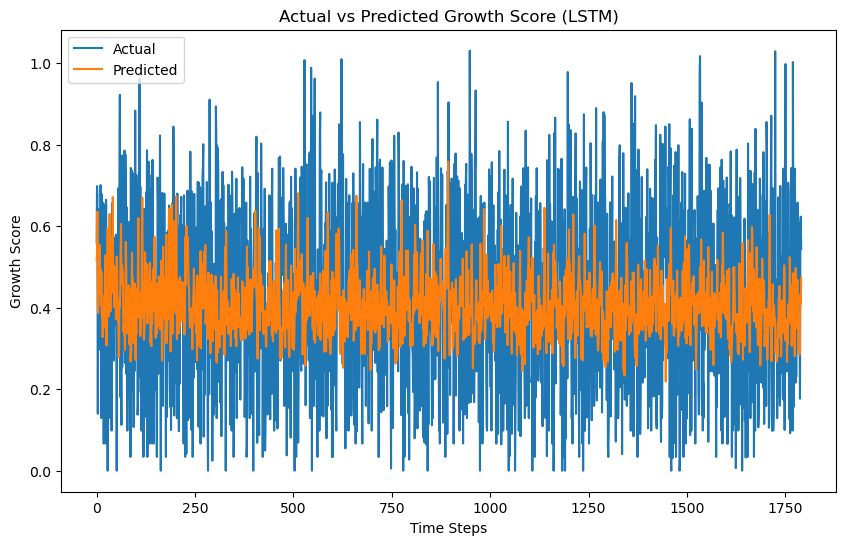

In [101]:
plt.figure(figsize=(10, 6))
plt.plot(y_actual, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Growth Score')
plt.title('Actual vs Predicted Growth Score (LSTM)')
plt.legend()

plt.show()

Considering the model is overpredicting. For this reason it would be important to conduct a residual analysis to better understand the cause of this overprediction.

In [102]:
residuals = y_actual - y_pred
print(residuals)

[0.04197989 0.16736289 0.03758229 ... 0.17858409 0.21434867 0.07071599]


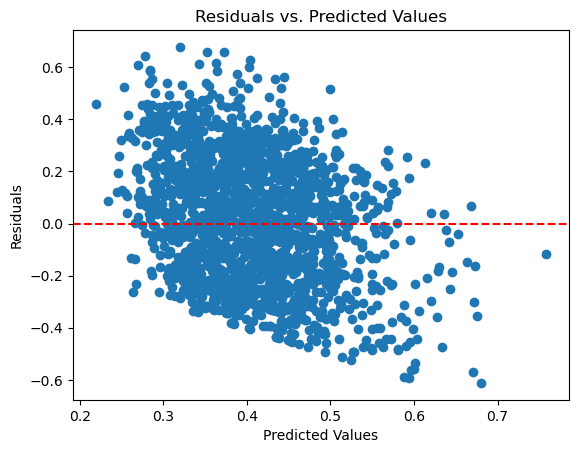

In [103]:
# Residuals vs. predicted values
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

Most of the points are below 0 indicating that the model is not a good fit, suggesting that there's a systematic error in the data.
There is a slight downward trend in the residuals, indicating that the errors are not randomly distributed around 0. This could suggest that there is some non-linearity in the relationship between the input and the target. 

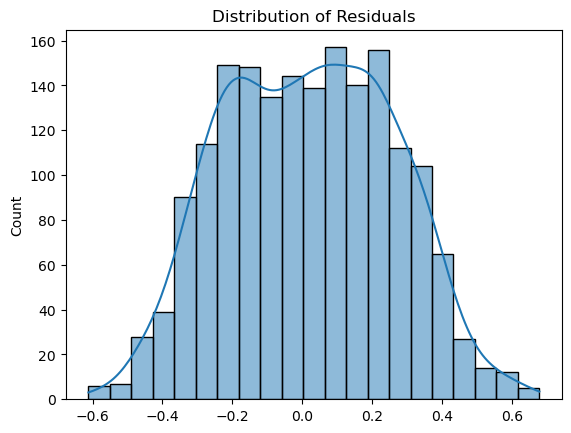

In [104]:
# Histogram of residuals
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.show()

If residuals follow a bell-shaped curve centered around zero, the model’s errors are likely normally distributed.

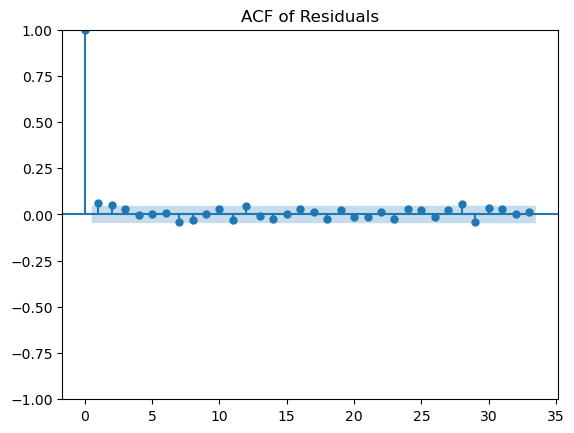

In [105]:
# Plot autocorrelation of residuals
plot_acf(residuals)
plt.title('ACF of Residuals')
plt.show()

If the ACF plot shows significant spikes, it means the residuals are autocorrelated, suggesting the model is missing important temporal patterns.

In [106]:
mse = mean_squared_error(y_actual, y_pred)
mae = mean_absolute_error(y_actual, y_pred)

print(f'MSE: {mse}', f'y_actual: {y_actual.mean()}', f'y_pred: {y_pred.mean()}')
print(f'MAE: {mae}')

MSE: 0.058544966335712954 y_actual: 0.42400114705238906 y_pred: 0.406005859375
MAE: 0.20290407883170394


__MSE__: 0.0585 - Indicates the average squared difference between predicted and actual growth scores. Lower is better.
__MAE__: 0.2029 - Shows the average absolute error between predictions and actual values. A lower value means better performance.

The model’s predictions are generally close to the actual values, but it tends to underestimate slightly. The errors suggest there's room for improvement, particularly in reducing prediction deviations.

#### Forecasting

In [107]:
def forecast_growth(model, initial_data, n_steps, scaler, timesteps=5, n_features=133):

    forecasted_values = []
    input_seq = initial_data[-timesteps:]  # Start with the last available data
    
    for _ in range(n_steps):
        # Prepare the input by reshaping (3D: 1 × timesteps × features)
        input_seq_reshaped = input_seq.reshape(1, timesteps, n_features)

        # Predict the next step (3D output)
        next_pred_scaled = model.predict(input_seq_reshaped)

        # For GRU and LSTM model with return_sequences=False
        next_pred = scaler.inverse_transform(next_pred_scaled)

        # Append the forecasted value
        forecasted_values.append(next_pred[0, 0])
        
        # Create a new input sequence with the predicted value
        next_input = input_seq[-1].copy()  # Copy last row of input sequence
        next_input[-1] = next_pred[0, 0] 

        # Update the input sequence by shifting and appending the new prediction
        input_seq = np.concatenate([input_seq[1:], next_input.reshape(1, -1)], axis=0)  # Shift and append
    
    return np.array(forecasted_values)


n_forecast_steps = 12 
scaler_y = joblib.load('../models/final_target_scaler.pkl')
initial_data = X_test_scaled_pca[-n_timesteps:]

print(n_timesteps, n_features_pca) 
print(initial_data.shape) 
print(X_test_scaled_pca.shape)
print(X_test_scaled_pca[-n_timesteps:].shape)
print(y_test_scaled[-n_timesteps:].shape)
print(n_features_pca)

# Perform the forecasting using the GRU model with attention
forecasted_values = forecast_growth(
    model=model, 
    initial_data=initial_data, 
    n_steps=n_forecast_steps, 
    scaler=scaler_y, 
    timesteps=n_timesteps, 
    n_features=n_features_pca
)

# Print the forecasted growth scores
print("Forecasted Growth Scores:", forecasted_values)

6 170
(6, 170)
(1797, 170)
(6, 170)
(6, 1)
170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Forecasted Growth Scores: [0.58209544 0.7015519  0.8133509  0.88993734 0.95514905 0.94447935
 1.0012385  1.039223   1.0720108  1.1001073  1.1250356  1.1477052 ]


#### Ploting the Forecast

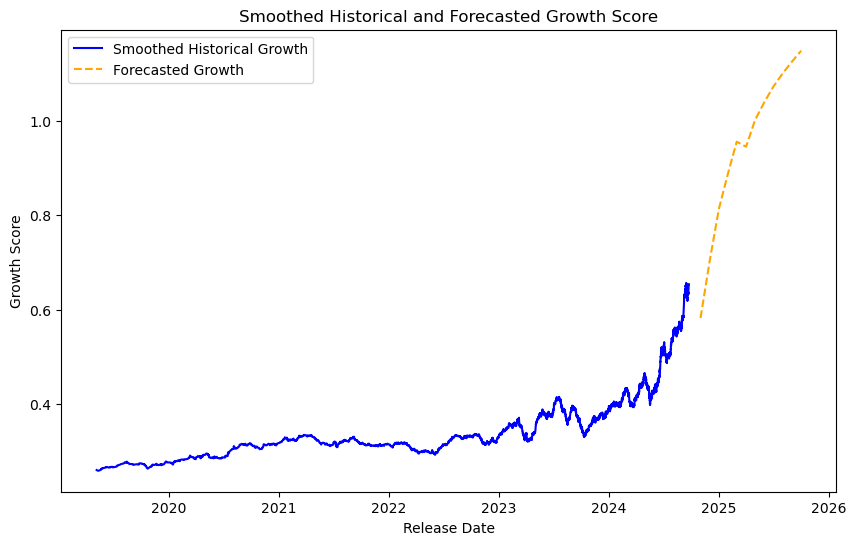

In [108]:
# Generate future dates for the forecasted values based on the release_date index by Monthly frequency
forecasted_dates = pd.date_range(start=df_cleaned_with_lag.index[-1], periods=n_forecast_steps + 1, freq='M')[1:]

# Apply a rolling average to smooth historical data because of the large data spikes
df_cleaned_with_lag['smoothed_growth_score'] = df_cleaned_with_lag['growth_score'].rolling(window=300).mean()

# Plot the smoothed historical growth score and forecasted data
plt.figure(figsize=(10, 6))
plt.plot(df_cleaned_with_lag.index, df_cleaned_with_lag['smoothed_growth_score'], color='blue', label='Smoothed Historical Growth')
plt.plot(forecasted_dates, forecasted_values, color='orange', linestyle='--', label='Forecasted Growth')

plt.xlabel('Release Date')
plt.ylabel('Growth Score')
plt.title('Smoothed Historical and Forecasted Growth Score')
plt.legend()
plt.show()